# Optimizing the outflow problem

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


In [2]:
path = '../../data/clean/'
SEED = 12


## Step 0: Naive model (RW)

First, let's load our main dataset with UNCHR covariates and consider the list of countries to make outflow predictions on.

In [3]:
data_outflows = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)
data_outflows = data_outflows.reset_index()
data_outflows["year"] = data_outflows["year"].dt.year

In [4]:
# Rename target column
data_outflows = data_outflows.rename(columns={'newarrival': 'ref_outflow'})

data_outflows.shape


(4900, 19)

In [5]:
# Store the list of countries to predict

iso_3 = data_outflows.iso_o.unique().tolist()

len(iso_3)

196

In [6]:
# Create train/test split
test_time_start = 2019
test_time_end = 2021
train = data_outflows.loc[data_outflows.year < test_time_start]
test = data_outflows.loc[(data_outflows.year >= test_time_start) & (data_outflows.year <= test_time_end)]

In [7]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="ref_outflow", lst_countries=iso_3,
                                              country_var='iso_o'
                                              )


In [8]:
mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.ref_outflow, squared=False)
print("Mse Naive RW: " + str(mse_naive))

Mse Naive RW: 61448.997839135656


In [9]:
data = {
    'iso_o': test.iso_o,
    'year': test.year,
    'y_test': test.ref_outflow,
    'y_naive': y_naive
}
predictions = pd.DataFrame(data)
predictions

,iso_o,year,y_test,y_naive
19,ABW,2019,1.0,0.0
20,ABW,2020,0.0,1.0
21,ABW,2021,0.0,0.0
44,AFG,2019,130489.0,116209.0
45,AFG,2020,74965.0,130489.0
...,...,...,...,...
4870,ZMB,2020,86.0,142.0
4871,ZMB,2021,73.0,86.0
4894,ZWE,2019,3371.0,1908.0
4895,ZWE,2020,1196.0,3371.0


In [10]:
mse_naive_dict = {}

for year in range(2019, 2022):
    data_year = predictions.loc[predictions.year == year]
    mse = mean_squared_error(y_pred=data_year.y_naive, y_true=data_year.y_test, squared=False)
    mse_naive_dict[year] = mse
    print("MSE Naive RW: " + str(mse_naive_dict[year]))


MSE Naive RW: 79330.72846959482
MSE Naive RW: 69261.51134685859
MSE Naive RW: 15408.3280317721


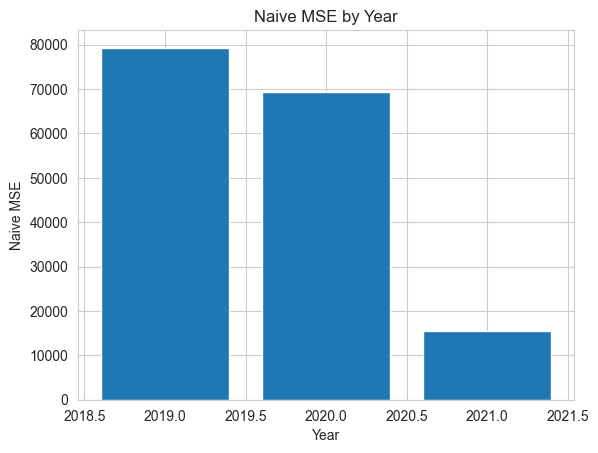

In [11]:
years = mse_naive_dict.keys()
mse_values = mse_naive_dict.values()

plt.bar(years, mse_values)
plt.xlabel('Year')
plt.ylabel('Naive MSE')
plt.title('Naive MSE by Year')
plt.show()


## Step 1: Baseline RF using UNCHR covariates and lags for selected features

We are adding lags for different columns.

Apart from lags, we might want to add rolling sums for:
- best estimate for casualties from conflict
- refugee outflows

In [12]:
shift_cols_2 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_1 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]


shifted_df_filled_1 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_1, range(1, 2), 'iso_o', 'year')
shifted_df_filled_2 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_2, range(1, 3), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_1.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_2.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)




Because later on we only keep 2005 onwards, let's start training this model with data>=2005: 

In [13]:
unhcr = unhcr[unhcr["year"]>=2005]

In [14]:
unhcr.head()

,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,Shift_2_ref_outflow,Shift_2_dead_o,Shift_2_best_est_o,Shift_2_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
5,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Binary encoding and scaling

In [15]:
unhcr.columns

Index(['iso_o_continent', 'iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o',
       'GDP_PPP_o', 'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o', 'ref_outflow', 'Shift_1_CPI_o',
       'Shift_1_GDP_PP_o', 'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o',
       'rolling_sum_past_3_ref_outflow', 'rolling_sum_past_5_ref_outflow',
       'rolling_sum_past_10_ref_outflow', 'rolling_sum_past_3_best_est_o',
       'rolling_sum_past_5_best_est_o', 'rolling_sum_past_10_best_est_o'],
      dtype='object')

In [16]:
# This are the times for X_train, which will predict one year ahead
test_time_start = 2018
test_time_end = 2020

unhcr["target"] = unhcr.groupby('iso_o').ref_outflow.shift(-1)


In [17]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1), 
                                      df=unhcr,
                                      binary_cols=binary_cols)

In [18]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr, 'target', test_time_start, test_time_end, 'year')


In [19]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1', BinaryEncoder(),
                                                  ['iso_o', 'iso_o_continent',
                                                   'Shift_1_typeOfViolence_o',
                                                   'typeOfViolence_o']),
                                                 ('num', RobustScaler(),
                                                  ['rolling_sum_past_5_ref_outflow',
                                                   'rolling_sum_past_10_best_est_o',
                                                   'Shift_1_ref_outflow',
                                                   'Shift_1_GDP_PP_o', 'CPI_o',
                                                   'rolling_sum_past_5_best...
                                                   'Nyear_conf_o', 'island_o',
                                                   'Shift_1_GDP_PPP_o',
                                                   'dead_log_o',
                                                   'rolling_sum_past_3_ref_outflow',
                                                   'landlocked_o',
                                                   'Shift_1_Nyear_conflict_o',
                                                   'ref_outflow',
                                                   'rolling_sum_past_3_best_est_o',
                                                   'Shift_1_Nyear_conf_o',
                                                   'Shift_2_best_est_o',
                                                   'area_o',
                                                   'rolling_sum_past_10_ref_outflow',
                                                   'Nyear_conflict_o', ...])])),
                ('rf', RandomForestRegressor(n_jobs=-1, random_state=12))])

In [20]:
y_pred = rf_pipe.predict(X_test)

y_pred = np.clip(y_pred, 0, None)

In [21]:
mse_unhcr = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - UNHCR covariates only: " + str(mse_unhcr))
print("Relative RMSE to Naive predictions: " + str(mse_unhcr/mse_naive))

RMSE outflows - UNHCR covariates only: 56998.02495755848
Relative RMSE to Naive predictions: 0.9275663877671503


In [22]:
predictions["y_unhcr"]=y_pred

### Rolling window

In [23]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr, 'target', test_time_start, test_time_end, 'year')

In [24]:
mse_unhcr_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    rf_pipe.fit(X_train, y_train)

    y_pred = rf_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_unhcr_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_unhcr_dict[year+1] = mse_unhcr_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("X_test uses data from: " + str(X_test.year.max()))
    print("RMSE outflows - UNHCR covariates: " + str(mse_unhcr_year))
    print("Relative RMSE to Naive predictions: " + str(mse_unhcr_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_unhcr_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
X_test uses data from: 2018
RMSE outflows - UNHCR covariates: 58785.06774566973
Relative RMSE to Naive predictions: 0.741012579610943
*********
Year: 2020
X_train uses data until: 2018
X_test uses data from: 2019
RMSE outflows - UNHCR covariates: 56691.85686442819
Relative RMSE to Naive predictions: 0.8185189113260593
*********
Year: 2021
X_train uses data until: 2019
X_test uses data from: 2020
RMSE outflows - UNHCR covariates: 29037.804063513697
Relative RMSE to Naive predictions: 1.884552561682066


In [25]:
mse_unhcr_dict

{2019: 58785.06774566973, 2020: 56691.85686442819, 2021: 29037.804063513697}

In [26]:
mse_unhcr_rw = mean_squared_error(y_true=predictions.y_test, y_pred=predictions_df.y_pred_unhcr_rw, squared=False)

print("RMSE outflows - UNHCR covariates only: " + str(mse_unhcr_rw))
print("Relative RMSE to Naive predictions: " + str(mse_unhcr_rw/mse_naive))

RMSE outflows - UNHCR covariates only: 119757.37173018977
Relative RMSE to Naive predictions: 1.948890558698724


## Step 2: Adding Google Trends data

+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ weighted trends - trends multiplied by population and internet penetration in the country

In [27]:
english_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_EN.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
ol_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_orig_lang.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])
ol_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_OL.csv").drop_duplicates()

topics = pd.read_csv("../trends/data/semantic_topic_trends_2005.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
# topics.info() - nulls in country, dropping those
topics = topics[topics.country.isnull()==False]
print(topics.shape)

print(english_from_topics.shape)
# english_boss.info() # A bunch of missing dates - idk what happened there!
# We can't do much without dates so I'm dropping them - will have to check if it's worth re-downloading this 
english_boss = english_boss[english_boss.date.isnull()==False].drop(columns=["index"])
print(english_boss.shape)


# I downloaded data for a maximum of two origin languages. This might not be the best approach, but for now, I'm averaging the values when I have more than one OL.
ol_from_topics_av = ol_from_topics.groupby(['country', 'date']).mean().reset_index()
ol_boss_av = ol_boss.groupby(['country', 'date']).mean().reset_index()
# Print the transformed dataset
print(ol_from_topics_av.shape)
print(ol_boss_av.shape)

C:\Users\danid\AppData\Local\Temp\ipykernel_49580\31775143.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])


(42098, 8)
(21816, 22)
(12096, 41)
(30240, 22)
(27216, 41)


Big merge:

In [28]:
# Let's merge first keywords - english and OL - separately

english = pd.merge(english_from_topics, english_boss, on=["date", "country"], how="outer")
ol = pd.merge(ol_from_topics_av, ol_boss_av, on=["date", "country"], how="outer")
print(english.shape)
print(ol.shape)

# Get the keywords listed 
keywords = english.columns[~english.columns.isin(['country', 'date'])]
print(keywords)
topics_list = topics.columns[~topics.columns.isin(['country', 'date'])]
print(topics_list)

(24408, 61)
(30240, 61)
Index(['passport', 'Immigration', 'Travel Visa', 'Refugee', 'Conflict', 'War',
       'Violence', 'Crisis', 'Militia', 'Genocide', 'Armed Forces', 'Civilian',
       'Currency', 'Lottery', 'Economy', 'Wage', 'Protest', 'Government',
       'Bureau de change', 'Coup d’état', 'asylum', 'citizen',
       'citizenship+citizenships', 'consulate+consulates', 'crises+crisis',
       'diaspora', 'embassy+embassies', 'emigration', 'foreigner+foreigners',
       'immigrant+immigrants', 'migrate', 'migration',
       'nationality+nationalities', 'recruitment+recruitments',
       'refugee+refugees', 'repatriation', 'Schengen', 'student visa',
       'visa free', 'visa+visas', 'work visa', 'emigrant+emigrants',
       'devaluation', 'immigrate+immigrated',
       'legalization+legalisation+legalisations+legalizations',
       'naturalization+naturalisation+naturalisations+naturalizations',
       'recession+recessions', 'smuggler+smugglers+smuggling',
       'deportation+de

In [29]:
# Create a mapping dictionary for renaming the columns
rename_dict_ol = {var: f"{var}_ol" for var in keywords}
rename_dict_en = {var: f"{var}_en" for var in keywords}
rename_dict_topics = {var: f"{var}_topic" for var in topics_list}
# Rename the columns using the mapping dictionary

english_2 = english.copy()
ol_2 = ol.copy()
topics_2 = topics.copy()

english_2.rename(columns=rename_dict_en, inplace=True)
ol_2.rename(columns=rename_dict_ol, inplace=True)
topics_2.rename(columns=rename_dict_topics, inplace=True)

In [30]:
big_merge = pd.merge(english_2, ol_2, on=["country", "date"], how="outer").merge(topics_2, on=["country", "date"], how="outer")
print(big_merge.shape)
print(big_merge.columns)

(42530, 126)
Index(['date', 'passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=126)


Average and max values in the year:

In [31]:
avg_trends = big_merge.copy()
avg_trends["iso_o"] = avg_trends["country"].apply(lambda x: model_helpers.convert_iso2_to_iso3(x))
avg_trends.set_index('date', inplace=True)
avg_trends.index = pd.DatetimeIndex(avg_trends.index)
avg_trends = avg_trends.drop(columns=["country"])

# Group by 'iso_o' and resample by YEAR, then mean the values

avg_trends_1 = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).mean().reset_index()
avg_trends_1['year'] = avg_trends_1['date'].dt.year
avg_trends_1 = avg_trends_1.drop(columns=["date"])

# Taking max 

max_trends = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).max().reset_index()
max_trends['year'] = max_trends['date'].dt.year
max_trends = max_trends.drop(columns=["date"])

keywords_new = avg_trends_1.columns[~avg_trends_1.columns.isin(['iso_o', 'year'])]

# Create a mapping dictionary for renaming the columns
rename_dict_avg = {var: f"{var}_avg" for var in keywords_new}
rename_dict_min = {var: f"{var}_min" for var in keywords_new}
rename_dict_max = {var: f"{var}_max" for var in keywords_new}

avg_trends_1.rename(columns=rename_dict_avg, inplace=True)
max_trends.rename(columns=rename_dict_max, inplace=True)

print(avg_trends_1.shape)
print(max_trends.shape)

(3722, 126)
(3722, 126)


In [32]:
avg_trends_1_smoothed = avg_trends_1.apply(model_helpers.smooth_spikes)
max_trends_smoothed = max_trends.apply(model_helpers.smooth_spikes)

Rolling sums (all vars)

In [33]:
# First: monthly aggregation - the data comes monthly automatically when downloading large periods, 
# but because we are not controlling that necessarily during download, just in case

monthly = avg_trends.groupby(['iso_o', pd.Grouper(freq='M')]).mean().reset_index()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly = monthly.drop(columns=["date"])
monthly.shape # it's actually not necessary, same shape

(42530, 127)

In [34]:
final_keywords_list = monthly.columns[~monthly.columns.isin(['year', 'month', 'iso_o'])]
print(final_keywords_list)

Index(['passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       'Genocide_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=124)


In [35]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(monthly, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,passport_en,Immigration_en,Travel Visa_en,Refugee_en,Conflict_en,War_en,Violence_en,Crisis_en,Militia_en,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,ABW,0.0,0.0,NaN,0.0,18.0,0.0,0.0,60.0,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
24,ABW,0.0,27.0,NaN,42.0,0.0,43.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
36,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
48,ABW,0.0,0.0,NaN,0.0,0.0,8.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42481,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
42493,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
42505,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
42517,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


In [36]:
trends_final = pd.merge(avg_trends_1_smoothed, max_trends_smoothed, how='outer', on=["iso_o", "year"])
trends_final = pd.merge(trends_final, panel_trends.drop(columns=["month"]), how='outer', on=["iso_o", "year"])
trends_final

,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,23.833333,12.166667,NaN,24.333333,13.416667,9.416667,8.333333,5.250000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,NaN,1.916667,10.583333,23.583333,4.083333,16.583333,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
2,ABW,2.583333,5.833333,NaN,10.666667,3.416667,16.250000,0.000000,10.583333,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
3,ABW,4.333333,3.916667,NaN,5.166667,2.583333,10.666667,4.250000,7.083333,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
4,ABW,2.416667,4.333333,NaN,0.000000,2.666667,10.583333,2.250000,5.416667,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
3718,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
3719,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
3720,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


NaN imputation - replace with 0, assuming very low searches/no searches

In [37]:
trends_final = trends_final.fillna(0)

In [38]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

In [39]:
value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})


In [40]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'year', 'pop_o', 'internet', 'ref_outflow']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged = trends_merged.fillna(0)
trends_merged.shape


(3528, 625)

In [41]:
trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
trends_merged = trends_merged.drop(columns=["ref_outflow"])


C:\Users\danid\AppData\Local\Temp\ipykernel_49580\2165611857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)


In [42]:
binary_cols=["iso_o"]
rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(random_state=SEED, n_jobs=-1),
                                      df=trends_merged, 
                                      binary_cols=binary_cols)

In [43]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [44]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only: " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only: 80245.0184495304
Relative RMSE to Naive predictions: 1.3058800187368382


Google trends on its own holds similar predicting power than knowing the refugee outflows for the last year.

In [45]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_tw"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

# Compute RMSE for each row
predictions['naive_error'] = np.sqrt((predictions['y_test'] - predictions['y_naive']) ** 2)
predictions['RF_error_trends'] = np.sqrt((predictions['y_test'] - predictions['y_pred_tw']) ** 2)


C:\Users\danid\AppData\Local\Temp\ipykernel_49580\1947740483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_tw"]=y_pred


### Rolling window

In [46]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [47]:
mse_gtrends_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    rf_pipe.fit(X_train, y_train)

    y_pred = rf_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_gtrends_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gtrends_dict[year+1] = mse_gtrends_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("X_test uses data from: " + str(X_test.year.max()))
    print("RMSE outflows - gtrends: " + str(mse_gtrends_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gtrends_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gtrends_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_trends = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
X_test uses data from: 2018
RMSE outflows - gtrends: 112396.25892558073
Relative RMSE to Naive predictions: 1.4168060862904968
*********
Year: 2020
X_train uses data until: 2018
X_test uses data from: 2019
RMSE outflows - gtrends: 29277.079762455796
Relative RMSE to Naive predictions: 0.42270344947914107
*********
Year: 2021
X_train uses data until: 2019
X_test uses data from: 2020
RMSE outflows - gtrends: 37536.57099863263
Relative RMSE to Naive predictions: 2.4361222659091832


In [48]:
predictions_df = pd.merge(predictions_df, predictions_df_trends, on=["year", "iso_o"], how="outer")


## Step 3. Augmented model: UNHCR covariates + Google Trends

IMPORTANT NOTE ABOUT THE Y: when I first implemented the UNHCR baseline model, I lagged all of the covariates by 1 and dropped the originals.

Here, because I will be merging the UNHCR dataset to the trends dataset, and the trends dataset already has the `target` variable generated considering 1 shift, I will keep the UNHCR covariates as they are (besides considering some lags and rolling sums to add value to the prediction). 

In [49]:
print(trends_merged.shape)

(3528, 625)


In [50]:
trends_merged = trends_merged.drop(columns=["pop_o"])

In [51]:
trends_merged = trends_merged.drop(columns=["target"])
merged_trends_cov = pd.merge(unhcr, trends_merged, on=["iso_o", "year"], how="left")

merged_trends_cov = merged_trends_cov[(merged_trends_cov.year<2022) & (merged_trends_cov.year >2004)]



In [52]:
merged_trends_cov = merged_trends_cov.fillna(0)
print(merged_trends_cov.shape)
merged_trends_cov.head()

(3332, 665)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic,internet
0,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,25.4
1,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,91.476,0.0,0.0,0.000,0.000,0.000,0.000,171.864,171.864,28.0
2,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.000,0.0,0.0,71.070,71.070,142.140,142.140,0.000,0.000,30.9
3,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,63.024,0.0,0.0,115.544,115.544,0.000,0.000,52.520,52.520,52.0
4,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.000,0.0,0.0,0.000,0.000,53.244,53.244,0.000,0.000,58.0


In [53]:
#def select_rows_with_nan(data):
 #  return data[data.isnull().any(axis=1)]

#selected_rows = select_rows_with_nan(merged_trends_cov)


In [54]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

rf_pipe = model_helpers.pipeline_tree(model=RandomForestRegressor(n_jobs=-1,
                                                                  random_state=SEED),
                                                                  df=merged_trends_cov,
                                                                  binary_cols=binary_cols)

In [55]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')


In [56]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE outflows - GTrends + UNHCR covariates: 57232.60109524956
Relative RMSE to Naive predictions: 0.9313837997012744


In [57]:
gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=merged_trends_cov,
                                                                  binary_cols=binary_cols)
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE outflows - GTrends + UNHCR covariates: 54577.85360361537
Relative RMSE to Naive predictions: 0.88818134587796


In [58]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

C:\Users\danid\AppData\Local\Temp\ipykernel_49580\1917419157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug"]=y_pred


In [59]:

# Compute RMSE for each row
predictions['GB_error_aug'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug']) ** 2)
predictions['RF_error_unhcr'] = np.sqrt((predictions['y_test'] - predictions['y_unhcr']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
predictions['actual_range'] = pd.cut(predictions['y_test'], ranges, labels=labels, include_lowest=True)



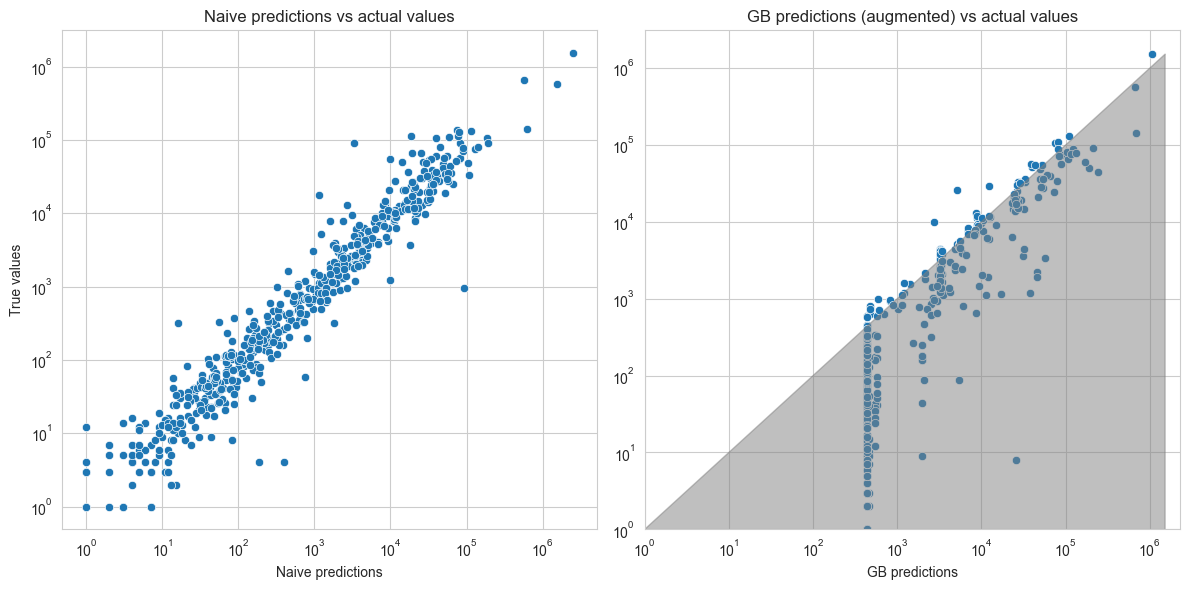

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions, x='y_naive', y='y_test', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')


# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions, x='y_pred_aug', y='y_test', ax=axes[1])
axes[1].set_xlabel('GB predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('GB predictions (augmented) vs actual values')

# Get the maximum value from x and y axes
max_val = max(predictions['y_test'].max(), predictions['y_pred_aug'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[1].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[1].set_xlim(left=1)
axes[1].set_ylim(bottom=1)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()




## Rolling window

In [61]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')



In [76]:
mse_aug_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    rf_pipe.fit(X_train, y_train)

    y_pred = rf_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_aug_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_aug_dict[year+1] = mse_aug_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - aug covariates: " + str(mse_aug_year))
    print("Relative RMSE to Naive predictions: " + str(mse_aug_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_aug_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_aug = pd.concat(predictions_list, ignore_index=True)


*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - aug covariates: 78786.54028167218
Relative RMSE to Naive predictions: 0.9931402597906155
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - aug covariates: 41439.915597292405
Relative RMSE to Naive predictions: 0.5983108770145534
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - aug covariates: 32343.16817898461
Relative RMSE to Naive predictions: 2.099070587820608


In [72]:
predictions_df = pd.merge(predictions_df, predictions_df_aug, on=["year", "iso_o"], how="outer")

In [64]:
mse_aug_dict

{2019: 78786.54028167218, 2020: 41439.915597292405, 2021: 32343.16817898461}

In [73]:
predictions_merged = pd.merge(predictions, predictions_df, on=["iso_o", "year"], how="left")

In [75]:
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_aug_rw, squared=False)/mse_naive

0.9924216135900004

In [67]:
# Compute mean RMSE for each group

predictions_merged['RF_error_trends'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_tw']) ** 2)
predictions_merged['RF_error_unhcr_rw'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_unhcr_rw']) ** 2)
predictions_merged['RF_error_aug_rw'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_aug_rw']) ** 2)

grouped_errors = predictions_merged[['naive_error', 'RF_error_unhcr', 'RF_error_trends', 'GB_error_aug', 'RF_error_unhcr_rw', 'RF_error_aug_rw', 'actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error_unhcr,RF_error_trends,GB_error_aug,RF_error_unhcr_rw,RF_error_aug_rw
actual_range,,,,,,
0-10,11.844444,72.638333,2345.728800,921.497333,18.005333,28.414222
10-100,27.416000,41.789120,3755.929425,505.531455,37.554240,36.162080
100-1k,875.694030,2630.681306,17794.536429,641.231021,3223.057500,1691.280821
1k-10k,1657.674242,5217.008220,17445.226755,4421.915763,4598.538750,4034.468939
10k-100k,16174.526316,38542.608684,38839.084231,20767.275665,31589.092474,35875.760842
100k+,180280.727273,210899.619091,167058.930000,143175.554866,169264.908182,160944.796364


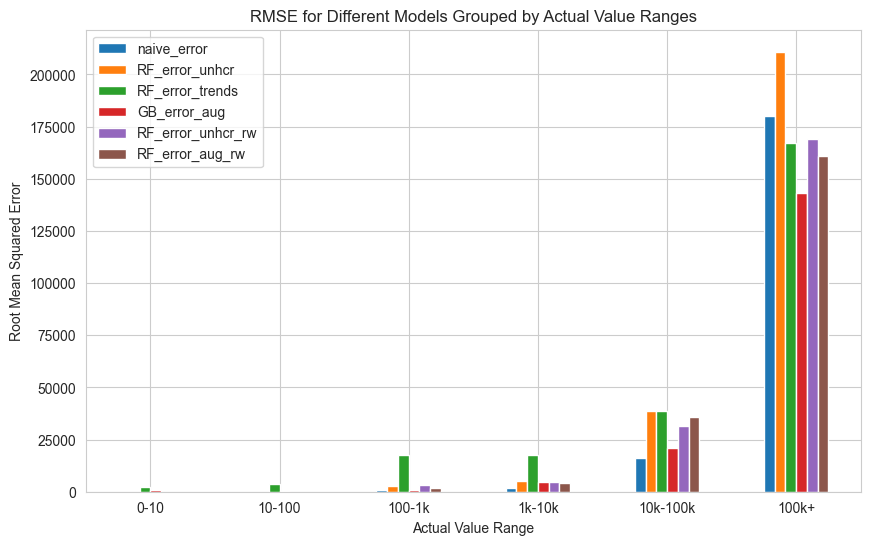

In [68]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

## Step 4. Augmented model + extra covariates

#### MIGRATION


In [77]:

migration = pd.read_csv(path + 'migration_stocks.csv')

migration = migration.groupby(['iso_o', 'year'])['migration_stock'].sum().reset_index()

migration['migration_change'] = migration.groupby('iso_o')['migration_stock'].pct_change() * 100

migration = migration.fillna(0)


In [78]:
aug_1 = pd.merge(merged_trends_cov, migration, on=["iso_o", "year"], how="left")
print(migration.shape)
print(aug_1.shape)
print(merged_trends_cov.shape)
aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]

(4900, 4)
(3332, 667)
(3332, 665)


C:\Users\danid\AppData\Local\Temp\ipykernel_49580\1238760211.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]


In [79]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_1, 'target', test_time_start, test_time_end, 'year')

In [80]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_1,
                                                                  binary_cols=binary_cols)
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration: 52613.86523218056
Relative RMSE to Naive predictions: 0.8562200700150691


### Rolling window

In [81]:
gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_1,
                                                                  binary_cols=binary_cols)
           

In [82]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_1, 'target', test_time_start, test_time_end, 'year')

In [83]:
mse_mig_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_mig_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_mig_dict[year +1] = mse_mig_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_mig_year))
    print("Relative RMSE to Naive predictions: " + str(mse_mig_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_mig_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_mig = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration covariates: 64825.68546115624
Relative RMSE to Naive predictions: 0.8171573198902624
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration covariates: 76588.94806941977
Relative RMSE to Naive predictions: 1.1057937746386401
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration covariates: 45008.705259335715
Relative RMSE to Naive predictions: 2.92106354216547


In [84]:
predictions_merged = pd.merge(predictions_merged, predictions_df_mig, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_mig_rw, squared=False)/mse_naive


1.0332606959103117

### Rolling window + log transformation (Y)

In [85]:
gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_1,
                                                                  binary_cols=binary_cols)

In [86]:
mse_mig_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_mig_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_mig_log_dict[year+1] = mse_mig_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_mig_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_mig_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_mig_rw_log": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_mig = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - migration covariates: 70604.36566467404
Relative RMSE to Naive predictions: 0.8900002184113898
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - migration covariates: 10084.176211080467
Relative RMSE to Naive predictions: 0.1455956708853689
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - migration covariates: 40099.24238379379
Relative RMSE to Naive predictions: 2.60243955743341


In [87]:
predictions_merged = pd.merge(predictions_merged, predictions_df_mig, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_mig_rw_log, squared=False)/mse_naive


0.768754044229935

## GDELT

In [88]:
def avg_log_diff(series):
    val = np.log1p(series).diff().mean()
    if np.isnan(val):
        return 0
    else:
        return val

# Define the agg_year function
def agg_year(series):
    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum, log_diff]

def agg_year_reduc(series):
    # Calculate the statistics using numpy
    mean = np.mean(series)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [mean, maximum, log_diff]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','mean','75th','max', 'log_diff'])
    return df

def split_nested_list_reduc(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['mean','max', 'log_diff'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

def split_df_reduc(df):
    new_df = pd.concat([split_nested_list_reduc(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

In [89]:
gdelt = pd.read_csv(path + 'gdelt.csv', engine='pyarrow')

gdelt = gdelt.groupby(['isocode','year'])[['count_events_1',
       'count_events_2', 'count_events_3', 'count_events_4', 'count_events_5',
       'count_events_6', 'count_events_7', 'count_events_8', 'count_events_9',
       'count_events_10', 'count_events_11', 'count_events_12',
       'count_events_13', 'count_events_14', 'count_events_15',
       'count_events_16', 'count_events_17', 'count_events_18',
       'count_events_19', 'count_events_20']].agg(agg_year)
gdelt = split_df(gdelt)

In [90]:
gdelt = gdelt.reset_index()
gdelt = gdelt.rename(columns={'isocode': 'iso_o'})



In [91]:
aug_gdelt = pd.merge(aug_1, gdelt, on=["iso_o", "year"], how="left")
print(aug_gdelt.shape)
aug_gdelt.head()


(3332, 788)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,count_events_19_mean,count_events_19_75th,count_events_19_max,count_events_19_log_diff,count_events_20_min,count_events_20_25th,count_events_20_mean,count_events_20_75th,count_events_20_max,count_events_20_log_diff
0,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.000000,0.004950,0.040000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.000000,0.000000,0.133333,-0.007277,0.0,0.0,0.0,0.0,0.0,0.0
2,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.016556,0.037393,0.076923,0.000917,0.0,0.0,0.0,0.0,0.0,0.0
3,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.000000,0.005774,0.200000,0.001388,0.0,0.0,0.0,0.0,0.0,0.0
4,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.011753,0.025073,0.173077,0.011851,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')


In [93]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_gdelt,
                                                                  binary_cols=binary_cols)
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))


RMSE outflows - GTrends + UNHCR covariates + Migration: 54234.13672437937
Relative RMSE to Naive predictions: 0.8825878147981564


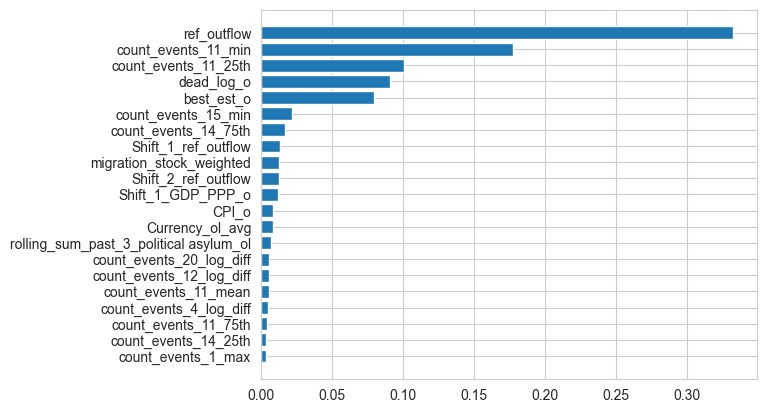

In [94]:
numerical_cols = list(set(aug_gdelt.columns) - set(binary_cols  + ['year', 'target']))

importances = gb_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)


In [95]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt"]=y_pred

predictions_merged = pd.merge(predictions_merged, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions_merged['GB_error_aug_gdelt'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_aug_gdelt']) ** 2)



C:\Users\danid\AppData\Local\Temp\ipykernel_49580\980089077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt"]=y_pred


### Rolling window GDELT

In [96]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

In [97]:
mse_gdelt_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_gdelt_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gdelt_dict[year+1] = mse_gdelt_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_gdelt_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gdelt_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gdelt_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_gdelt = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - migration covariates: 56053.62627825722
Relative RMSE to Naive predictions: 0.706581514623819
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - migration covariates: 74958.18163190245
Relative RMSE to Naive predictions: 1.082248714679574
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - migration covariates: 35479.62116852539
Relative RMSE to Naive predictions: 2.302626287249734


In [98]:
predictions_merged = pd.merge(predictions_merged, predictions_df_gdelt, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_gdelt_rw, squared=False)/mse_naive

0.9404776800134409

With log transformation of Y:

In [99]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

# Add a small constant to handle zero values
epsilon = 1e-8
y_train_log = np.log(y_train + epsilon)

gb_pipe.fit(X_train, y_train_log)

# Predict on test set and transform back to original scale
y_pred_log = gb_pipe.predict(X_test)
y_pred = np.exp(y_pred_log) 

mse_aug_gdelt = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + GDELT: " + str(mse_aug_gdelt))
print("Relative RMSE to Naive predictions: " + str(mse_aug_gdelt / mse_naive))

RMSE outflows - GTrends + UNHCR covariates + GDELT: 44873.3480110219
Relative RMSE to Naive predictions: 0.7302535369005311


With rolling window:

In [100]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_gdelt,
                                                                  binary_cols=binary_cols)

X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

In [101]:
mse_gdelt_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_gdelt_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gdelt_log_dict[year+1] = mse_gdelt_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration + gdelt covariates: " + str(mse_gdelt_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gdelt_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gdelt_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_gdelt_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - migration + gdelt covariates: 55180.091622754924
Relative RMSE to Naive predictions: 0.6955702120383763
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - migration + gdelt covariates: 29893.674635349456
Relative RMSE to Naive predictions: 0.4316058667221865
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - migration + gdelt covariates: 42798.97807668444
Relative RMSE to Naive predictions: 2.777652318177066


In [103]:
predictions_merged = pd.merge(predictions_merged, predictions_df_gdelt_log, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_gdelt_log_rw, squared=False)/mse_naive

0.713708732708016

Adding conflict covariates

In [104]:
conflict = pd.read_csv(path + 'mueller_conflict_forecasts.csv')

conflict = conflict.drop(columns=['ons_armedconf12_pred_jut_x',
       'ons_armedconf12_pred_jut_y', 'lnbest_pc_12_pred_jut'])

# apply this to conflict data
conflict = conflict.groupby(['isocode', 'year'])[['ons_armedconf12_pred_top_x', 'ons_armedconf12_pred_aug_x', 
                                                   'ons_armedconf12_pred_top_y', 'ons_armedconf12_pred_aug_y', 
                                                  'lnbest_pc_12_pred_top', 'lnbest_pc_12_pred_aug']].agg(agg_year)

conflict = split_df(conflict)


conflict = conflict.reset_index()
conflict = conflict.rename(columns={'isocode': 'iso_o'})



In [109]:
aug_conflict = pd.merge(aug_gdelt, conflict, on=["iso_o", "year"], how="left")
print(aug_conflict.shape)
aug_conflict.head()

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_conflict, 'target', test_time_start, test_time_end, 'year')

(3332, 824)


In [110]:
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

gb_pipe = model_helpers.pipeline_tree(model=GradientBoostingRegressor(random_state=SEED),
                                                                  df=aug_conflict,
                                                                  binary_cols=binary_cols)
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_conflict = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + GDELT + Conflict: " + str(mse_aug_conflict))
print("Relative RMSE to Naive predictions: " + str(mse_aug_conflict/mse_naive))


RMSE outflows - GTrends + UNHCR covariates + GDELT + Conflict: 45767.04319869106
Relative RMSE to Naive predictions: 0.7447972271004709


In [123]:

X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_conflict, 'target', test_time_start, test_time_end, 'year')


mse_conflict_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    
    mse_conflict_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_conflict_dict[year+1] = mse_conflict_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows + conflict covariates: " + str(mse_conflict_year))
    print("Relative RMSE to Naive predictions: " + str(mse_conflict_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_conflict_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_conflict_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows + conflict covariates: 50242.60018565801
Relative RMSE to Naive predictions: 0.633330881424019
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows + conflict covariates: 64988.87702495413
Relative RMSE to Naive predictions: 0.9383115638278914
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows + conflict covariates: 35850.900389227696
Relative RMSE to Naive predictions: 2.3267222968840513


In [124]:
predictions_merged = pd.merge(predictions_merged, predictions_df_conflict_log, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_conflict_rw, squared=False)/mse_naive

0.8421079717762949

In [111]:

X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_conflict, 'target', test_time_start, test_time_end, 'year')


mse_conflict_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_conflict_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_conflict_log_dict[year+1] = mse_conflict_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration + conflict covariates: " + str(mse_conflict_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_conflict_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_conflict_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_conflict_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - migration + conflict covariates: 40570.143183168824
Relative RMSE to Naive predictions: 0.511405151141631
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - migration + conflict covariates: 23064.232017795413
Relative RMSE to Naive predictions: 0.3330021475028282
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - migration + conflict covariates: 43768.6848944234
Relative RMSE to Naive predictions: 2.8405862598571376


In [112]:
predictions_merged = predictions_merged.drop(columns=["y_pred_conflict_log_rw"])

In [113]:
predictions_merged = pd.merge(predictions_merged, predictions_df_conflict_log, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_conflict_log_rw, squared=False)/mse_naive

0.6011417673802302

In [125]:
# Combine dictionaries into a single dictionary
combined_dict = {
    'Naive': mse_naive_dict,
    'UNHCR': mse_unhcr_dict,
    'GTrends': mse_gtrends_dict,
    'Augmented: UNHCR+GTrends': mse_aug_dict,
    'Augmented 2: Aug + Migration': mse_mig_dict,
    'Augmented 3: Aug2 + GDELT': mse_gdelt_dict,
    'Aug2 (log)': mse_mig_log_dict,
    'Aug3 (log)': mse_gdelt_log_dict,
    'Aug4: Aug3 + Conflict': mse_conflict_dict,
    'Aug4 (log)': mse_conflict_log_dict
}

# Create a DataFrame from the combined dictionary
mse_df = pd.DataFrame.from_dict(combined_dict)

# Print the DataFrame
mse_df




,Naive,UNHCR,GTrends,Augmented: UNHCR+GTrends,Augmented 2: Aug + Migration,Augmented 3: Aug2 + GDELT,Aug2 (log),Aug3 (log),Aug4: Aug3 + Conflict,Aug4 (log)
2019,79330.728470,58785.067746,112396.258926,78786.540282,64825.685461,56053.626278,70604.365665,55180.091623,50242.600186,40570.143183
2020,69261.511347,56691.856864,29277.079762,41439.915597,76588.948069,74958.181632,10084.176211,29893.674635,64988.877025,23064.232018
2021,15408.328032,29037.804064,37536.570999,32343.168179,45008.705259,35479.621169,40099.242384,42798.978077,35850.900389,43768.684894


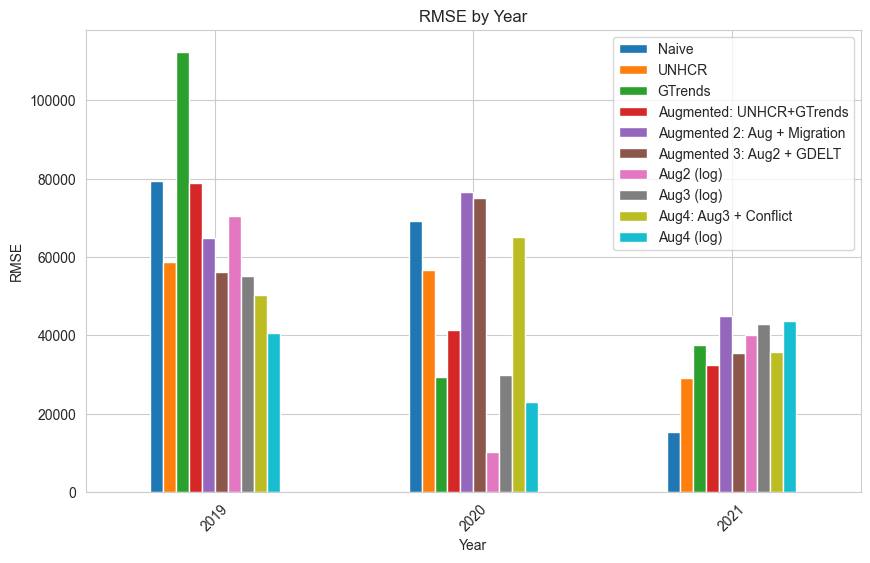

In [126]:
# Reset the index
mse_df_reset = mse_df.reset_index()

# Plotting the bar chart
mse_df_reset.plot.bar(x='index', figsize=(10, 6))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('RMSE by Year')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [127]:
relative_mse = mse_df.div(mse_df['Naive'], axis=0)

In [128]:
relative_mse

,Naive,UNHCR,GTrends,Augmented: UNHCR+GTrends,Augmented 2: Aug + Migration,Augmented 3: Aug2 + GDELT,Aug2 (log),Aug3 (log),Aug4: Aug3 + Conflict,Aug4 (log)
2019,1.0,0.741013,1.416806,0.993140,0.817157,0.706582,0.890000,0.695570,0.633331,0.511405
2020,1.0,0.818519,0.422703,0.598311,1.105794,1.082249,0.145596,0.431606,0.938312,0.333002
2021,1.0,1.884553,2.436122,2.099071,2.921064,2.302626,2.602440,2.777652,2.326722,2.840586


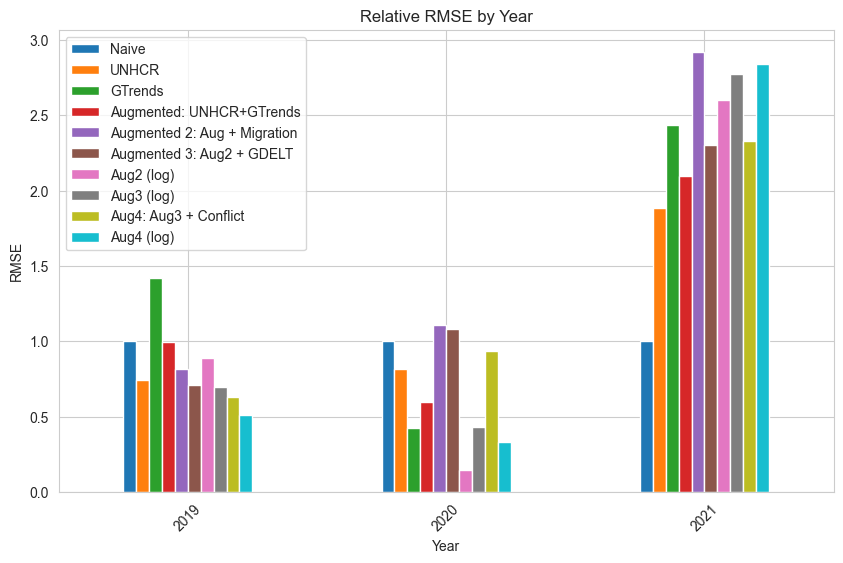

In [129]:
# Reset the index
relative_mse_reset = relative_mse.reset_index()

# Plotting the bar chart
relative_mse_reset.plot.bar(x='index', figsize=(10, 6))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Relative RMSE by Year')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [130]:
predictions_merged.columns

Index(['iso_o', 'year', 'y_test', 'y_naive', 'y_unhcr', 'y_pred_tw',
       'naive_error', 'RF_error_trends', 'y_pred_aug', 'GB_error_aug',
       'RF_error_unhcr', 'actual_range', 'y_pred_unhcr_rw',
       'y_pred_gtrends_rw', 'y_pred_aug_rw_x', 'y_pred_aug_rw_y',
       'y_pred_mig_rw', 'y_pred_mig_rw_log', 'y_pred_aug_gdelt',
       'GB_error_aug_gdelt', 'y_pred_gdelt_rw', 'y_pred_gdelt_log_rw',
       'y_pred_conflict_log_rw', 'Aug3_error_log', 'Aug3_error',
       'y_pred_conflict_rw'],
      dtype='object')

How biased are the estimates? Aug 4 + log

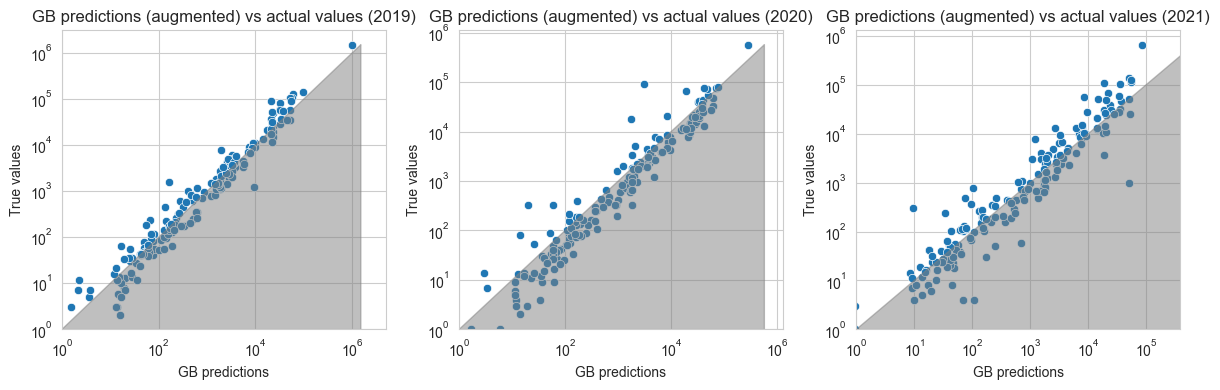

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

years = predictions_merged['year'].unique()

for i, year in enumerate(years):
    ax = axes.flatten()[i]
    data = predictions_merged[predictions_merged['year'] == year]
    
    # Plot the scatterplot for the current year
    sns.scatterplot(data=data, x='y_pred_conflict_log_rw', y='y_test', ax=ax)
    ax.set_xlabel('GB predictions')
    ax.set_ylabel('True values')
    ax.set_title(f'GB predictions (augmented) vs actual values ({year})')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set the lower limits of the x and y axes to 1
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=1)

    # Get the maximum value from x and y axes
    max_val = max(data['y_test'].max(), data['y_pred_conflict_log_rw'].max())

    # Create the diagonal line coordinates
    diagonal_line = np.linspace(0, max_val, 100)

    # Fill the area below the diagonal line in the current subplot
    ax.fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Comparing aug 3 (levels/logs)

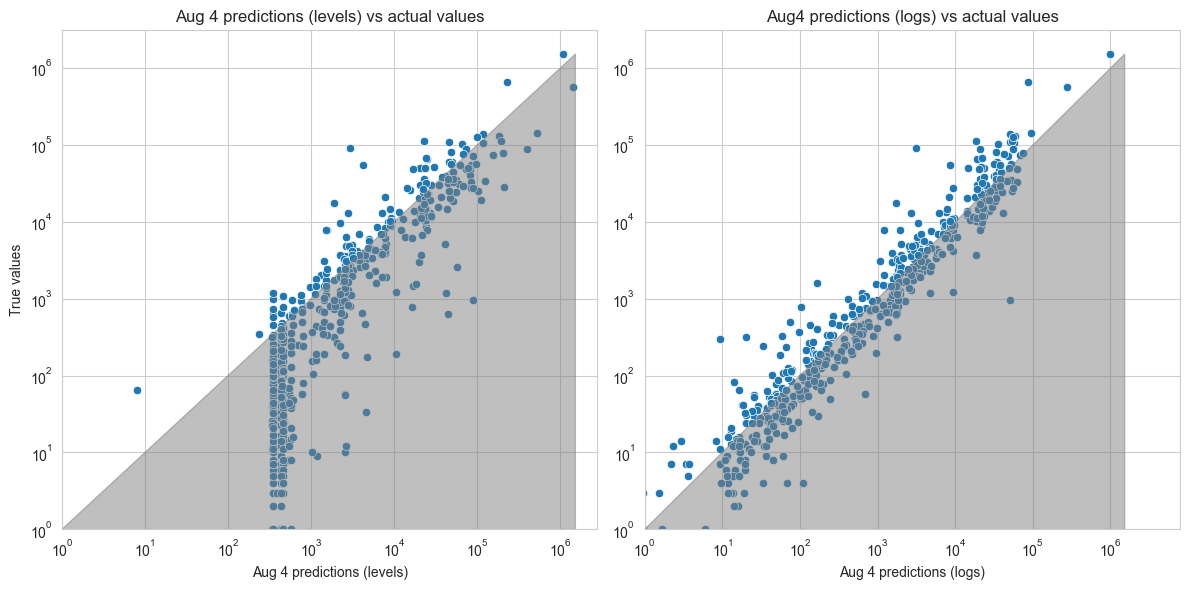

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions_merged, x='y_pred_conflict_rw', y='y_test', ax=axes[0])
axes[0].set_xlabel('Aug 4 predictions (levels)')
axes[0].set_ylabel('True values')
axes[0].set_title('Aug 4 predictions (levels) vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Get the maximum value from x and y axes
max_val = max(predictions_merged['y_test'].max(), predictions_merged['y_pred_conflict_rw'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[0].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[0].set_xlim(left=1)
axes[0].set_ylim(bottom=1)

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions_merged, x='y_pred_conflict_log_rw', y='y_test', ax=axes[1])
axes[1].set_xlabel('Aug 4 predictions (logs)')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Aug4 predictions (logs) vs actual values')

# Get the maximum value from x and y axes
max_val = max(predictions_merged['y_test'].max(), predictions_merged['y_pred_gdelt_log_rw'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[1].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[1].set_xlim(left=1)
axes[1].set_ylim(bottom=1)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [135]:
predictions_final = predictions_merged[["year", "iso_o", "y_naive", "y_pred_conflict_rw", "y_pred_conflict_log_rw"]]

In [134]:
predictions_final.to_csv("../../best predictions/outflows_best_rw (3-7).csv", index=False)

### Appendix

Adding COVID data (restrictions on international flights)

In [134]:
covid = pd.read_csv(path + "international-travel-covid.csv").drop(columns=["Entity"]).rename(columns={"Code":"iso_o"})
covid["Day"] = pd.to_datetime(covid["Day"])
covid["year"] = covid["Day"].dt.year
covid = covid.groupby(['iso_o','year'])[['international_travel_controls']].agg(agg_year)
covid = split_df(covid)

covid = covid.reset_index()
covid.head()

,iso_o,year,international_travel_controls_min,international_travel_controls_25th,international_travel_controls_mean,international_travel_controls_75th,international_travel_controls_max,international_travel_controls_log_diff
0,ABW,2020,0.0,1.0,3.0,3.0,4.0,0.001899
1,ABW,2021,1.0,1.0,1.0,3.0,3.0,0.000000
2,ABW,2022,0.0,0.0,0.0,0.0,1.0,-0.001904
3,AFG,2020,0.0,1.0,1.0,3.0,3.0,0.001899
4,AFG,2021,1.0,1.0,2.0,2.0,4.0,0.001114


In [135]:
aug_covid = pd.merge(aug_gdelt, covid, on=["iso_o", "year"], how="left")
aug_covid = aug_covid.fillna(0)
print(aug_covid.shape)
aug_covid.head()

(3332, 794)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,count_events_20_mean,count_events_20_75th,count_events_20_max,count_events_20_log_diff,international_travel_controls_min,international_travel_controls_25th,international_travel_controls_mean,international_travel_controls_75th,international_travel_controls_max,international_travel_controls_log_diff
0,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predictions with rolling window + log transformation

In [136]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_covid.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [137]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_covid, 'target', test_time_start, test_time_end, 'year')

In [139]:
mse_covid_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_covid_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_covid_log_dict[year+1] = mse_covid_log_year

    print("*********")
    print("Year: " + str(year+1))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - COVID covariates: " + str(mse_covid_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_covid_log_year / mse_naive_dict[year+1]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year+1] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_covid_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_covid_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2019
X_train uses data until: 2017
RMSE outflows - COVID covariates: 76973.54657103543
Relative RMSE to Naive predictions: 0.9702866475068003
*********
Year: 2020
X_train uses data until: 2018
RMSE outflows - COVID covariates: 29859.766748602662
Relative RMSE to Naive predictions: 0.43111630352774527
*********
Year: 2021
X_train uses data until: 2019
RMSE outflows - COVID covariates: 42798.95098871988
Relative RMSE to Naive predictions: 2.7776505601690262


COVID data doesn't improve results